<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Extract with NVTabular

In this set of labs, we'll learn how to use [NVTabular](https://nvidia-merlin.github.io/NVTabular/main/Introduction.html) to create an ETL pipeline. The first step to any ETL pipeline is to `Extract` data from an already existing database. We will be using NOAA's [Climate Data Online (CDO) Dataset](https://www.ncdc.noaa.gov/cdo-web/datasets#LCD). Specifically, we will be using the [U.S. Local Climatological Data (LCD)](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00684/html) which stores hourly climatological data for almost 2500 stations. It tracks temperature, dew point, precipitation and wind speeds among other things. A full description of the schema can be found in [this document](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/LCD_documentation.pdf).

Our goal is to:
1. Extract wind data from the LCD database
2. Transform it to better understand the direction in which the wind blows
3. Load it into a new file so others can use it for analysis

<b>Learning Objectives</b>:
* Learn how to use NVTabular to read multiple files at once
* Learn how to visualize NVTabular's system of operations with a graph
* Learn how to export data to a new file type for analysis
* Learn how to monitor GPU resources

### GPU Monitoring

Before we get started with NVTabular and transforming data, it would be useful to see how these data pipelines impact our hardware. For this lab, we have multiple GPUs available, and we would like to use each one of them to its fullest ability.

We are going to use the `nvidia-smi` command line tool to monitor our GPUs. Try running it below. We can also add a `-h` flag (commented out below) to see the full documentation of the command.

In [1]:
!nvidia-smi #-h

Sat Feb 12 07:23:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1B.0 Off |                    0 |
| N/A   24C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:1C.0 Off |                    0 |
| N/A   22C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

This displays useful information about our GPUs including:
* `GPU`: The ID number of the GPU.
* `Memory-Usage`: How much memory is on the GPU and how much if it has been used.
* `GPU-Util`: The percent utilization of the GPU over the last second.

Since there is only so much space our computer screens, let's customize our view of this tool. We can do so with the `--query-gpu` flag. We can pass it the specific properties we are interested in. Let's start with the following to monitor our GPU memory and utilization:

* `index`: Zero based index of the GPU. Can change at each boot.
* `memory.used`: Total memory allocated by active contexts.
* `memory.total`: Total installed GPU memory.
* `utilization.gpu`: Percent of time over the past sample period during which one or more kernels was executing on the GPU. The sample period may be between 1 second and 1/6 second depending on the product.

When querying, we must also specify a `--format`. Let's use `csv` in order to make the output human readable. 

In [2]:
!nvidia-smi --query-gpu=index,name,memory.used,memory.total,utilization.gpu --format=csv

index, name, memory.used [MiB], memory.total [MiB], utilization.gpu [%]
0, Tesla T4, 0 MiB, 15109 MiB, 0 %
1, Tesla T4, 0 MiB, 15109 MiB, 0 %
2, Tesla T4, 0 MiB, 15109 MiB, 0 %
3, Tesla T4, 0 MiB, 15109 MiB, 0 %


There are many more properties we can query. The following may also be of interest:

* `name`: The official product name of the GPU.
* `power.draw`: The last measured power draw for the entire board, in watts. Only available if power management is supported. This reading is accurate to within +/- 5 watts.
* `temperature.gpu`: Core GPU temperature. in degrees C.
A full list of properties can be found by running:
`nvidia-smi --help-query-gpu`

**TODO**: We can set this query to run periodically so we can see how our code impacts our GPU almost immediately. First, we should make a new terminal window. Create one by going to `File` > `New` > `Terminal`. This should create a new tab named `Terminal X` with `X` being the a number. Click and hold the tab name to move the tab around and place it where convenient, such as to the left or right edge or along the bottom. We recommend having both the notebook and the terminal visible on the screen.

Next, we will use the [watch](https://linux.die.net/man/1/watch) command line tool in order to continually run `nvidia-smi`. The `-n` flag specifies the number of seconds to wait between repeating a command.

Copy the following command into the new terminal window and run it by pressing the `ENTER` key. Feel free to modify which properties to query with the ones you are most interested in.

`watch -n0.1 nvidia-smi --query-gpu=index,memory.used,memory.total,utilization.gpu --format=csv`

### Getting Started with NVTabular

Now that we have our hardware monitoring set up, let's begin building our NVTabular data pipeline based on NOAA's Local Climatological Data.

We have already pulled the data for three stations and have stored them in the `data` folder. They are large files, so we do not recommend opening them in a Jupyter window. If you are interested in learning how to do this yourself, data can be ordered from the NOAA website using [this form](https://www.ncdc.noaa.gov/cdo-web/datatools/lcd). Up to ten years of data can be requested at a time, and email address is required for them to send the data to.

Let's load one of these files into cuDF in order to understand it better. (Keep an eye on your terminal as this is running to watch the GPU memory usage climb higher.)

In [3]:
import cudf
df = cudf.read_csv("data/2563867.csv")
df.head()

,Unnamed: 0,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,...,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,0,72058700184,2011-05-01T00:00:00,FM-15,4,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,72058700184,2011-05-01T00:15:00,AUTO,4,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2,72058700184,2011-05-01T00:35:00,AUTO,4,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,3,72058700184,2011-05-01T01:00:00,FM-15,4,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,4,72058700184,2011-05-01T01:15:00,AUTO,4,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


This dataset is **sparse**, meaning that most of the values are empty. Here, this empty data is displayed as `<NA>`. Let's look at the first few rows at the raw data to see what is happening.

In [4]:
!head data/2563867.csv

,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupElevationUnit,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,CDSD,CLDD,DSNW,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,DailyAverageWindSpeed,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,DailyWeather,HDSD,HTDD,HeavyFog,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlySkyConditions,HourlyStationPressure,HourlyVisi

See the long strings of commas? Those are many cells in a row without any data. The CSV file format does not offer much compression, so the first ETL pipeline we will make is to convert our CSV files in an [Apache Parquet](https://parquet.apache.org/) file.

### NVTabular

**[NVTabular](https://nvidia-merlin.github.io/NVTabular/main/Introduction.html#nvtabular-api-documentation)** is a library for fast tabular data transformation and loading, manipulating terabyte-scale datasets quickly. It provides best practices for feature engineering and preprocessing and a high-level abstraction to simplify code accelerating computation on the GPU using the RAPIDS cuDF library. It was originally created for Recommender System data pipelines, but it is not limited in this scope.

<center><img src='https://developer.nvidia.com/blog/wp-content/uploads/2020/07/recommender-system-training-pipeline-1.png'></center>

**NVTabular has 4 main components**:
* <b>1. Dataset</b>: A [dataset](https://nvidia-merlin.github.io/NVTabular/main/api/dataset.html#) contains a list of files and iterates over the files. If necessary, it will read a file in chunks.
* <b>2. Op</b>: An [Op](https://nvidia-merlin.github.io/NVTabular/main/api/ops/index.html) defines a calculation. For example, an op could be to collect the mean/std for a column, filling missing values or combine two categories.
* <b>3. Workflow</b>: A [workflow](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html) orchestrates the pipeline. We will take a more detailed look on that in the following notebooks.
* <b>4. Dataloader</b>: NVTabular provides optimized dataloader for tabular data in [PyTorch](https://nvidia-merlin.github.io/NVTabular/main/api/torch_dataloader.html) and [TensorFlow](https://nvidia-merlin.github.io/NVTabular/main/api/tensorflow_dataloader.html). This is primarily used for machine learning.

For our weather dataset, many of the columns in our raw dataset are empty, so let's define an NVTabular workflow. The steps are to:
1. Define a [ColumnGroup](https://nvidia-merlin.github.io/NVTabular/main/resources/architecture.html?highlight=columngroup)
2. Initialize the NVTabular workflow
3. Initialize the NVTabular dataset
4. Transform the dataset

In [5]:
import nvtabular as nvt
import pandas as pd

<b>1. Define a ColumnGroup</b>

As we define our pipeline, we will begin at the source. NVTabular reads the column names in our source files in order to locate data, so let's take a look at which columns have data in order to decide what to keep.

In [6]:
pd.options.display.max_rows = 200
df.count()

Unnamed: 0                                      250676
STATION                                         250676
DATE                                            250676
REPORT_TYPE                                     250676
SOURCE                                          250676
AWND                                                 0
BackupDirection                                      0
BackupDistance                                       0
BackupDistanceUnit                                   0
BackupElements                                       0
BackupElevation                                      0
BackupElevationUnit                                  0
BackupEquipment                                      0
BackupLatitude                                       0
BackupLongitude                                      0
BackupName                                           0
CDSD                                                 0
CLDD                                                 0
DSNW      

We can see that most of the daily, monthly, and short duration data is missing, but there is a good amount of hourly data. Let's extract these hourly columns to explore them further.

To do this, we will pass NVTabular a list of column names to create a [ColumnGroup](https://nvidia-merlin.github.io/NVTabular/main/resources/architecture.html?highlight=columngroup). In the next notebook, we will learn how to transform these columns with Ops, but for now, we will use the ColumnGroup to simply filter our data.

In [7]:
columns = [
    "STATION",
    "DATE",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyPrecipitation",
    "HourlyRelativeHumidity",
    "HourlyWetBulbTemperature",
    "HourlyWindDirection",
    "HourlyWindSpeed",
]
column_group = nvt.ColumnGroup(columns)

<b>2. Initialize the NVTabular workflow</b>

Next, we can initialize an NVTabular [workflow](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html) with our pipeline. This defines the system of operations to be done on our columns. To do this, it constructs a DAG with [Dask](https://dask.org/) that is visible by calling `.column_group.graph` on the workflow.

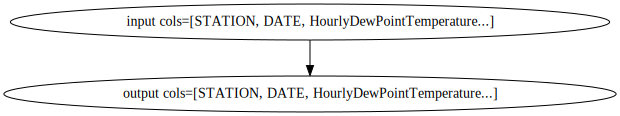

In [8]:
workflow = nvt.Workflow(column_group)
workflow.column_group.graph

For now, we are not transforming any data, so our graph only has two steps:
1. Extract the defined input columns
2. Output those defined input columns

<b>3. Initialize the NVTabular dataset</b>

NVTabular [Dataset](https://nvidia-merlin.github.io/NVTabular/main/api/dataset.html#) is a universal wrapper for datasets. The main purpose is to abstract away the raw format of the dataset and allow NVTabular to rely on a universal format. In addition, NVTabular Dataset partitions the data and if necessary reads the file in chunks to avoid exceeding the GPU memory.<br><br>
NVTabular [Dataset](https://nvidia-merlin.github.io/NVTabular/main/api/dataset.html#) supports multiple input formats, such as:
* reading data in format `.avro`, `.parquet` or `.csv` 
* reading data from different file storages: `local disk`, `AWS S3` or `Google Cloud Storage` 
* directly `cudf.DataFrame` or `dask_cudf.DataFrame`

If we want to pass in multiple files at once, we can do so with a list of file paths. Thankfully, the python [glob](https://docs.python.org/3/library/glob.html) module can give us exactly that:

In [9]:
import glob
file_paths = glob.glob("data/*.csv")
file_paths

['data/2565221.csv', 'data/2563867.csv', 'data/2565262.csv']

In [10]:
dataset = nvt.Dataset(file_paths)

In [12]:
dataset

<b>4. Transform the dataset</b>

Now that we have defined our workflow and data sources, we can run our pipeline to *load* our data into a new output destination.

We'll start by running our `dataset` through our simple workflow DAG with [transform](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html#nvtabular.workflow.workflow.Workflow.transform). Then, we will export it with [to_parquet](https://nvidia-merlin.github.io/NVTabular/main/api/dataset.html#nvtabular.io.dataset.Dataset.to_parquet).

*Note*: If we have already ran this pipeline before, we can clear out the previous result with the below code to make way for the new data.

In [13]:
!rm -rf data/parquet_out

As we have been setting up the pipeline, we have not been using our GPU resources. Watch that change as the below pipeline runs.

In [14]:
workflow.transform(dataset).to_parquet(output_path="data/parquet_out/")

Take a look at the new `data/parquet_out` folder. The entire directory is much smaller than any one of our CSV files.

In [15]:
!ls data/* -lh

-rw-r--r-- 1 root root  73M Feb 12 07:13 data/2563867.csv
-rw-r--r-- 1 root root  64M Feb 12 07:13 data/2565221.csv
-rw-r--r-- 1 root root  34M Feb 12 07:13 data/2565262.csv

data/parquet_out:
total 14M
-rw-r--r-- 1 root root  14M Feb 12 07:26 0.39e087bc67604a55ad924b2dac9fc2c6.parquet
-rw-r--r-- 1 root root   62 Feb 12 07:26 _file_list.txt
-rw-r--r-- 1 root root 5.1K Feb 12 07:26 _metadata
-rw-r--r-- 1 root root  136 Feb 12 07:26 _metadata.json


### Review the output

Even though our pipeline ran, it does not mean the data was exported correctly. Let's take a look on our processed data to verify that is as expected.

In [16]:
df_output = cudf.read_parquet("data/parquet_out/*.parquet")
df_output.head(10)

,STATION,DATE,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindSpeed
0,72058700184,2011-05-01T00:00:00,72.0,75.0,<NA>,89.0,<NA>,130.0,9.0
1,72058700184,2011-05-01T00:15:00,72.0,75.0,<NA>,89.0,<NA>,120.0,9.0
2,72058700184,2011-05-01T00:35:00,72.0,75.0,<NA>,89.0,<NA>,120.0,11.0
3,72058700184,2011-05-01T01:00:00,72.0,75.0,<NA>,89.0,<NA>,130.0,14.0
4,72058700184,2011-05-01T01:15:00,72.0,75.0,<NA>,89.0,<NA>,130.0,13.0
5,72058700184,2011-05-01T01:35:00,72.0,75.0,<NA>,89.0,<NA>,130.0,10.0
6,72058700184,2011-05-01T02:00:00,72.0,75.0,<NA>,89.0,<NA>,130.0,11.0
7,72058700184,2011-05-01T02:15:00,72.0,75.0,<NA>,89.0,<NA>,130.0,10.0
8,72058700184,2011-05-01T02:35:00,72.0,75.0,<NA>,89.0,<NA>,130.0,13.0
9,72058700184,2011-05-01T03:00:00,73.0,75.0,<NA>,94.0,<NA>,130.0,8.0


Excellent, this is more manageable for us to analyze. In this notebook, we showed how to `Extract` and `Load` with NVTabular, but not how to `Transform`. We will learn how to do so in the [next notebook](2_Transforming_with_Ops.ipynb).

Before moving on, please shutdown the Jupyter notebook kernel to free GPU memory. Keep an eye on that terminal to watch as everything drops back to 0.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>